<a href="https://colab.research.google.com/github/Ankitkumar803/U-net-for-image-segmentation-from-scratch--PyTorch/blob/main/U_Net_Implementation_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls '/content/gdrive/My Drive/'
%cd /content/gdrive/My Drive/polyp_seg/data/polyDB
! pwd

Mounted at /content/gdrive
'Awsome segmentation'   LULC   polyp_seg
/content/gdrive/My Drive/polyp_seg/data/polyDB
/content/gdrive/My Drive/polyp_seg/data/polyDB


In [2]:
# ! rm images/train/output_coco_format.json

rm: cannot remove 'images/train/output_coco_format.json': No such file or directory


## Adding padding to images to make them square shape - 812*812
## u-net works with certain image size only, becuase of its architecture

torch.Size([3, 812, 812])


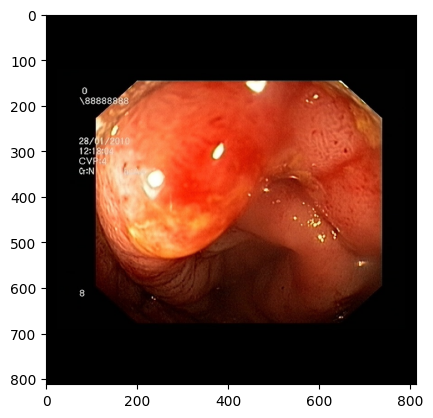

In [3]:
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt

def pad_image_to_square(img):


  channels, height, width = img.size()
  diff = abs(812-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2

  # to make it 812*812
  img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)
  # print(img.shape)

  # print("hey" , img.size())

  channels, height, width = img.size()
  diff = abs(height-width)
  # Determine the amount of padding to add on each side
  padding = diff // 2


  # Pad the tensor with zeros along the height and width dimensions
  if height < width:
      padded_image = torch.nn.functional.pad(img, (0, 0, padding, diff - padding), mode='constant', value=0)
  else:
      padded_image = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)


  return padded_image


# Open the rectangular image
img = read_image('./images/train/0a2fd84b-e62b-4153-beab-75d7d8757f75.jpg')


# Pad the image to make it square
padded_img = pad_image_to_square(img)
print(padded_img.shape)

tensor_image = padded_img.permute(1, 2, 0)
plt.imshow(tensor_image)
plt.show()


## Creating DataLoader

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image


class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform , target_transform):
        self.img_path = img_path
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img = pad_image_to_square(img)

        if self.target_path:
          img_path_tar = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])

          target = cv2.imread(img_path_tar , 0)
          mask_contour= cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(target,mask_contour[0],0,255, -1)
          target = target[np.newaxis, :, :]
          target = torch.from_numpy(target)
          target = pad_image_to_square(target)
        else :
          target = torch.tensor([])


        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            # print("target", target.shape, type(target))
            target = self.target_transform(target)
            target = torch.where(target > 128, torch.tensor([1.0]), torch.tensor([0.0]))

        return img.float(), target.float()



# Define the transformation to resize the images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((252, 252))   # 572 , 572
    # transforms.ToTensor()
])

transform1 = transforms.Compose([
    transforms.Resize((68, 68))   # 388 , 388'

])
# Instantiate dataset object
dataset = CustomDataset(

    img_path = './images/train' ,
    target_path = './masks/train' ,
    transform=transform ,
    target_transform = transform1 )

test_dataset = CustomDataset(
    img_path = './images/test' ,
    target_path = None ,
    transform=transform ,
    target_transform = None
    )

# justto check number of images
img_path = './images/train'
print(len(os.listdir(img_path)))
target_path = './masks/train/'
print(len(os.listdir(target_path)))


import torch.utils.data as data
train_dataset, val_dataset = data.random_split(dataset, [799, len(dataset) - 799]) # Ensure the lengths sum to the dataset length


# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True) #,worker_init_fn=lambda _: random.seed(42))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False) #,worker_init_fn=lambda _: random.seed(42))



2750
2750


### showing some of the images

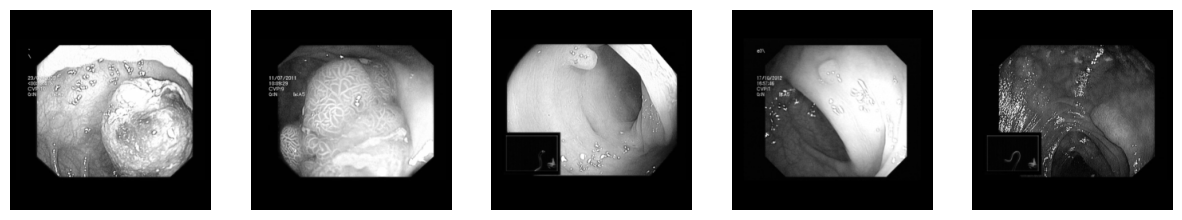

In [5]:
import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[0][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

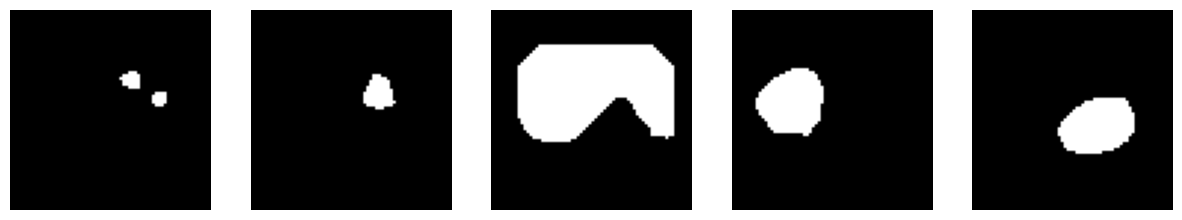

In [6]:
import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, batch in enumerate(train_dataloader):
  if i == 1:
      break
  # print(f"Batch {i+1}: {batch}")

  # Plot each image in a separate subplot
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(5):
      axs[i].imshow(batch[1][i, 0], cmap='gray')
      axs[i].axis('off')
  plt.show()
  i+=1

## Defining U-net Architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def scale_tensor(image ,new_height , new_width):
  scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
  return scaled_image


#double 3x3 convolution
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

def out_layer(in_channel , out_channel):
  conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1),
      nn.BatchNorm2d(out_channel),
      nn.Sigmoid()
  )
  return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path)
        #transpose convolution is used showna as green arrow in architecture image
        self.conv_bn=nn.BatchNorm2d(1024)

        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(128,64)

        #output layer
        # self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.out = out_layer(64 , 1)

    def forward(self, image):

        #Padding the image to make it sqare
        # image = pad_image_to_square(image)
        #forward pass for Left side

        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)


        #forward pass for Right side
        x_norm = self.conv_bn(x9)
        x = self.trans1(x_norm)
        y = crop_tensor(x, x7)
        # print(x.shape , y.shape)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))

        x = self.out(x)


        return x



In [8]:
# Enable GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training U-net

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from dataset import MyDataset
# from model import UNet

torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
# batch_size = 2
learning_rate = 0.001
num_epochs = 10



# Define the U-Net architecture
model = Unet()
if torch.cuda.is_available():
  model.cuda()

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss , train_loss = [] , []
# Train the U-Net
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets)
    val_loss /= len(val_dataloader)
  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")

# Save the trained model
# torch.save(model.state_dict(), 'path/to/trained/model')


RuntimeError: running_mean should contain 3 elements not 1

### 3. DICE Score on validation set

In [ ]:
def dice_coefficient(y_pred, y_true):
    smooth = 0.001
    y_pred = y_pred.view(-1)
    # print(type(y_pred), y_pred.shape)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    dice = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
    return dice

def dice_score(y_pred_batch, y_true_batch):
    dice_scores = torch.zeros(y_pred_batch.shape[0])
    for i in range(y_pred_batch.shape[0]):
        dice_scores[i] = dice_coefficient(y_pred_batch[i], y_true_batch[i])
    return dice_scores

with torch.no_grad():
  dice_com = torch.tensor([])
  model.to(device)
  model.eval()
  val_loss = 0
  for inputs, targets in val_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)#

      outputs = model(inputs)
      outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))
      dice = dice_score(outputs, targets)
      dice_com = torch.cat((dice_com, dice))

print("Dice Score of Validation Set")
dice_com.mean().item()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dice Score of Validation Set


0.8502498865127563

## DICE score - 0.8502

## 4. Validation and training loss plot

Text(0, 0.5, 'loss')

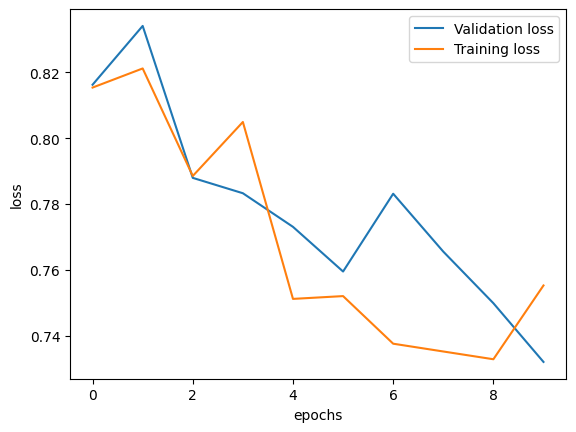

In [ ]:
import matplotlib.pyplot as plt
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/ML-Assign-6/model1.pt')
# model.load_state_dict(torch.load(model_path))

In [ ]:
# model = Unet()
# if torch.cuda.is_available():
#   model.cuda()
# model.load_state_dict(torch.load('/content/drive/MyDrive/ML-Assign-6/model.pt'))

<All keys matched successfully>

In [ ]:
import torch
torch.cuda.empty_cache()
# del model
import gc
gc.collect()

0

## Prediction on test set

In [ ]:
import itertools
# Get the first 2 batches
top_2_batches = list(itertools.islice(test_dataloader, 2))

out = []
test = []
test1 = []
# Process the batches
with torch.no_grad():
  for batch in top_2_batches:
      # Do something with the batch

      inputs = batch[0].to(device)   #

      test.append(inputs)
      test1.append(batch[1].to(device))

      outputs = model(inputs)
      out.append(outputs)

      torch.cuda.empty_cache()
      gc.collect()
      print(batch[0].shape)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([16, 1, 252, 252])
torch.Size([16, 1, 252, 252])


## some of predection on Test set



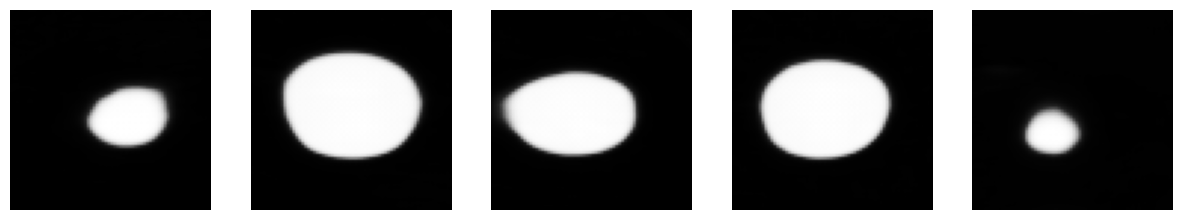

In [ ]:
import matplotlib.pyplot as plt
import torch

# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor = out[0].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

### corresponding images

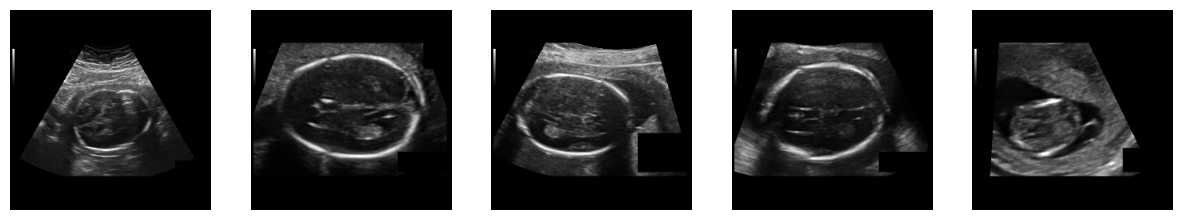

In [ ]:
import matplotlib.pyplot as plt
import torch

# Create a tensor of size [5, 1, 628, 628] (replace with your own tensor)
tensor_train = test[0].cpu().detach().numpy()

# Plot each image in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor_train[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()